<a href="https://colab.research.google.com/github/virslaan/-Linear-Models-for-Regression-and-Classification/blob/main/facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd 
import pathlib

from google.colab import drive
drive.mount('/drive')



Mounted at /drive


In [2]:
%cd /drive/MyDrive/facial_adl/
data_root = pathlib.Path('/drive/MyDrive/facial_adl')
print (data_root)

/drive/MyDrive/facial_adl
/drive/MyDrive/facial_adl


In [3]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

In [4]:
pip install scikit-plot


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [6]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:

df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [8]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [9]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


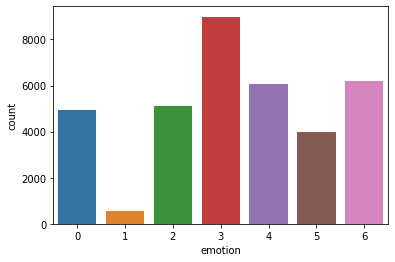

In [ ]:
sns.countplot(df.emotion)
pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral and we are using them only.`

In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

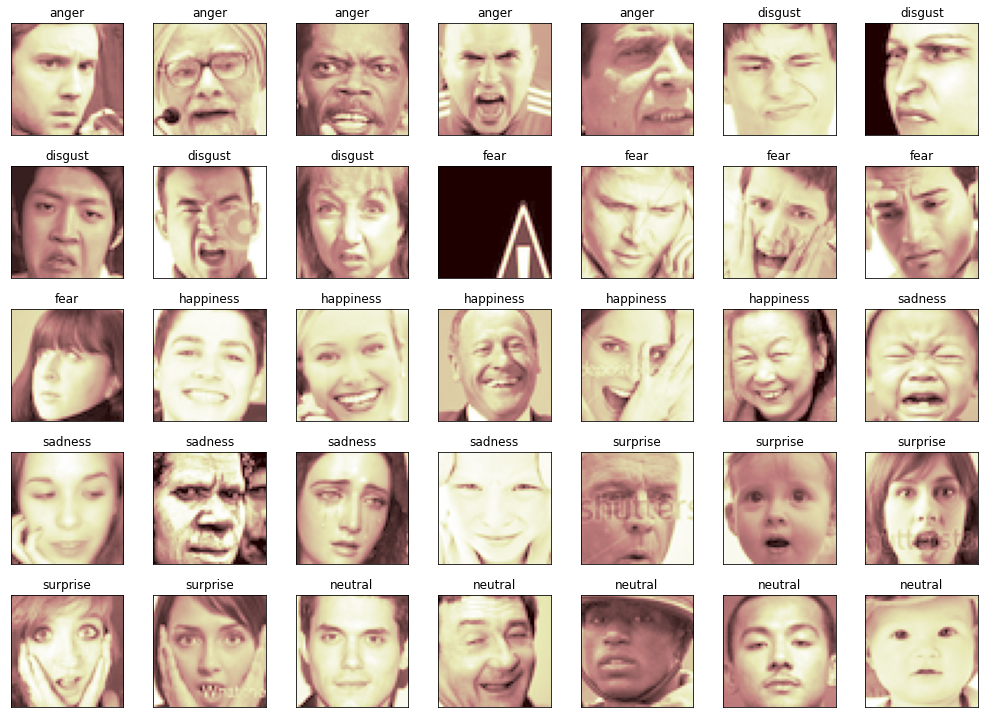

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(5):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
INTERESTED_LABELS = [3, 4, 6]

In [ ]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

`Now I will make the data compatible for neural networks.`

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(21264, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


`Splitting the data into training and validation set.`

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    model_nn = Sequential(name='My_DJ_Eyes')

    model_nn.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    model_nn.add(BatchNormalization(name='batchnorm_1'))
    model_nn.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    model_nn.add(BatchNormalization(name='batchnorm_2'))
    
    model_nn.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    model_nn.add(Dropout(0.4, name='dropout_1'))

    model_nn.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    model_nn.add(BatchNormalization(name='batchnorm_3'))
    model_nn.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    model_nn.add(BatchNormalization(name='batchnorm_4'))
    
    model_nn.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    model_nn.add(Dropout(0.4, name='dropout_2'))

    model_nn.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    model_nn.add(BatchNormalization(name='batchnorm_5'))
    model_nn.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    model_nn.add(BatchNormalization(name='batchnorm_6'))
    
    model_nn.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    model_nn.add(Dropout(0.5, name='dropout_3'))

    model_nn.add(Flatten(name='flatten'))
        
    model_nn.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model_nn.add(BatchNormalization(name='batchnorm_7'))
    
    model_nn.add(Dropout(0.6, name='dropout_4'))
    
    model_nn.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    model_nn.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    model_nn.summary()
    
    return model_nn

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.15,
    zoom_range=0.15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "My_DJ_Eyes"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


598/598 [==============================] - 17s 26ms/step - loss: 1.2711 - accuracy: 0.4237 - val_loss: 0.9155 - val_accuracy: 0.5656 - lr: 0.0010
Epoch 2/100
598/598 [==============================] - 15s 25ms/step - loss: 0.9758 - accuracy: 0.5222 - val_loss: 0.8091 - val_accuracy: 0.6145 - lr: 0.0010
Epoch 3/100
598/598 [==============================] - 18s 30ms/step - loss: 0.8679 - accuracy: 0.5808 - val_loss: 0.7420 - val_accuracy: 0.6577 - lr: 0.0010
Epoch 4/100
598/598 [==============================] - 15s 25ms/step - loss: 0.7684 - accuracy: 0.6416 - val_loss: 0.6764 - val_accuracy: 0.7015 - lr: 0.0010
Epoch 5/100
598/598 [==============================] - 15s 25ms/step - loss: 0.7261 - accuracy: 0.6664 - val_loss: 0.6582 - val_accuracy: 0.7090 - lr: 0.0010
Epoch 6/100
598/598 [==============================] - 15s 25ms/step - loss: 0.6868 - accuracy: 0.6947 - val_loss: 0.6077 - val_accuracy: 0.7372 - lr: 0.0010
Epoch 7/100
598/598 [==============================] - 19s 31ms/

In [ ]:
def plot(history, label):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  _ = plt.figure()
  plt.title('Training and validation accuracy - ' + str(label))
  plt.plot(epochs, acc, color='green', label='Train')
  plt.plot(epochs, val_acc, color='red', label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.grid(color='grey')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss - ' + str(label))
  plt.plot(epochs, loss, color='green', label='Train')
  plt.plot(epochs, val_loss, color='red', label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(color='grey')
  plt.legend()

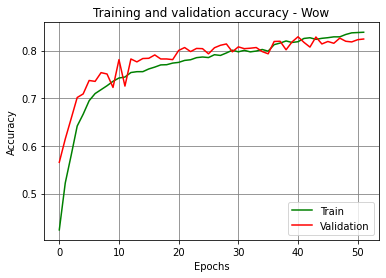

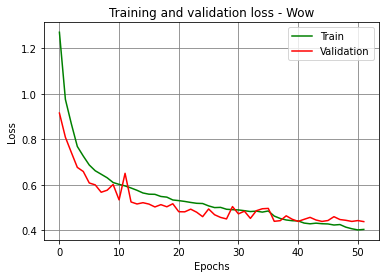

In [ ]:

plot(history,"Wow")

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as yaml_file:
    yaml_file.write(model_json)
    
model.save("my_model.h5")
model.save("/content/my_model.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

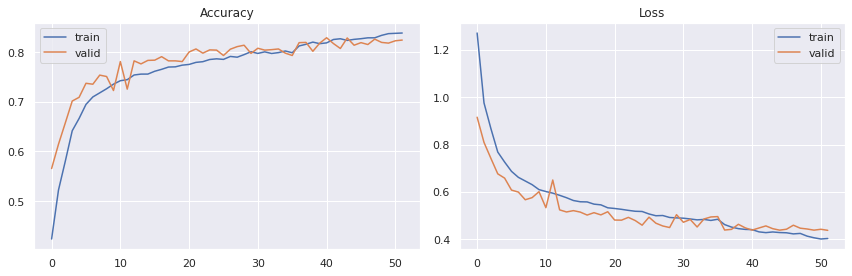

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

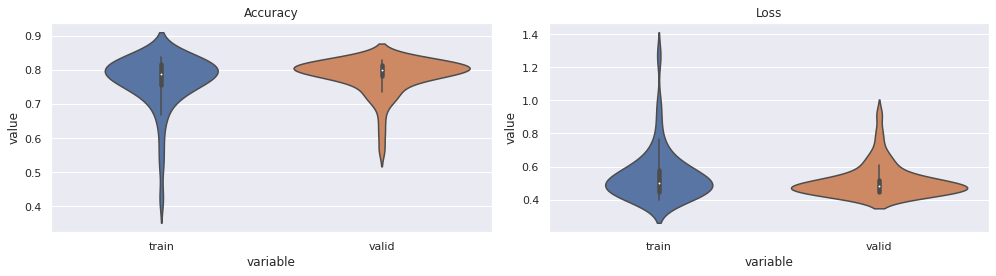

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

67/67 [==============================] - 1s 7ms/step
total wrong validation predictions: 364


              precision    recall  f1-score   support

           0       0.93      0.92      0.92       899
           1       0.79      0.75      0.77       608
           2       0.73      0.77      0.75       620

    accuracy                           0.83      2127
   macro avg       0.82      0.81      0.81      2127
weighted avg       0.83      0.83      0.83      2127



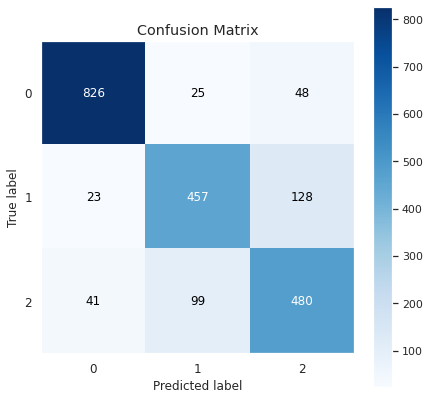

In [ ]:

yhat_valid=np.argmax(model.predict(X_valid),axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [ ]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

[[0.7058824  0.76862746 0.7921569  ... 0.47058824 0.43529412 0.40392157]
 [0.7019608  0.7607843  0.78039217 ... 0.4745098  0.4627451  0.41960785]
 [0.69411767 0.7490196  0.76862746 ... 0.28627452 0.31764707 0.34901962]
 ...
 [0.75686276 0.74509805 0.67058825 ... 0.41568628 0.39215687 0.3764706 ]
 [0.7607843  0.7490196  0.6862745  ... 0.41960785 0.39607844 0.36862746]
 [0.4509804  0.58431375 0.73333335 ... 0.42352942 0.39607844 0.36862746]]
1/1 [==============================] - 0s 110ms/step
[[0.4627451  0.45882353 0.4392157  ... 0.22352941 0.20784314 0.2       ]
 [0.48235294 0.5372549  0.47058824 ... 0.23529412 0.21568628 0.20784314]
 [0.4745098  0.50980395 0.5058824  ... 0.25490198 0.23529412 0.22352941]
 ...
 [0.01568628 0.01960784 0.03529412 ... 0.06666667 0.07058824 0.07450981]
 [0.03137255 0.03921569 0.04705882 ... 0.06666667 0.06666667 0.07450981]
 [0.04705882 0.05490196 0.05882353 ... 0.06666667 0.06666667 0.07843138]]
1/1 [==============================] - 0s 32ms/step
[[0.368

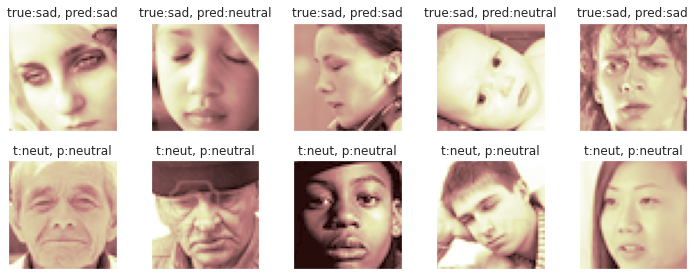

In [ ]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=5)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=5)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='pink')
        ax.set_xticks([])
        ax.set_yticks([])#np.argmax(model.predict(X_valid),axis=1)
        print(sample_img)
        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='pink')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")

        pyplot.tight_layout()

In [ ]:
#Making it work on real time

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms

In [ ]:

# Import the necessary libraries
from PIL import Image
from numpy import asarray
 
 
x= np.array(Image.open("/content/face.jpg").resize((48, 48)))
img = Image.open('/content/face.jpg')
numpydata = asarray(img)
 
# data
print(x.shape)

(48, 48, 3)


[[205 196 182 ... 190 186 183]
 [205 194 182 ... 200 196 190]
 [205 193 182 ... 159 165 167]
 ...
 [118 126 138 ...  12   6   5]
 [ 88  77  92 ...  10  14   7]
 [112 130 148 ...  11  24  15]]
1/1 [==============================] - 0s 142ms/step


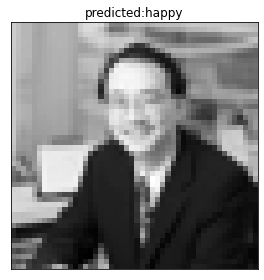

In [ ]:
from keras import models
model=models.load_model("/content/my_model.h5")
ax = pyplot.subplot(1,1,1)
sample_img = x[:,:,0]
print(sample_img)
ax.imshow(sample_img, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
x=np.argmax(model.predict(sample_img.reshape(1,48,48,1).astype('float32'))[0])
ax.set_title(f"predicted:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



pyplot.tight_layout()

In [ ]:

# Import the necessary libraries
from PIL import Image
from numpy import asarray
 
 
x= np.array(Image.open("/content/ko.jpeg").resize((48, 48)))


[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
1/1 [==============================] - 0s 153ms/step
[100.   0.   0.]


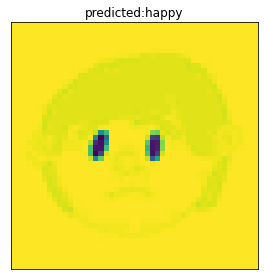

In [ ]:

from keras import models
model=models.load_model("/content/my_model.h5")
ax = pyplot.subplot(1,1,1)
sample_img = x[:,:,0]
print(sample_img)
ax.imshow(sample_img)
ax.set_xticks([])
ax.set_yticks([])
ans=model.predict(sample_img.reshape(1,48,48,1).astype('float32'))[0]
x=np.argmax(ans)
ax.set_title(f"predicted:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



pyplot.tight_layout()

print(ans*100)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
    files.download(images)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  images=Image(filename)
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

name 'files' is not defined


In [ ]:
x= np.array(images).resize((48, 48))

TypeError: ignored

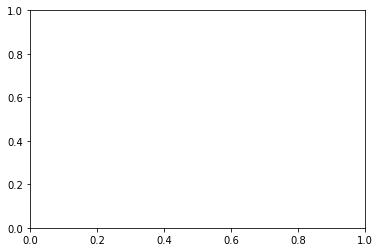

In [ ]:
ax = pyplot.subplot(1,1,1)
sample_img = x[:,:,0]
print(sample_img)
ax.imshow(sample_img)
ax.set_xticks([])
ax.set_yticks([])
ans=model.predict(sample_img.reshape(1,48,48,1).astype('float32'))[0]
x=np.argmax(ans)
ax.set_title(f"predicted:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



pyplot.tight_layout()

print(ans*100)